Loading sequences: 100%|██████████| 5095/5095 [00:00<00:00, 663313.74it/s]


Features saved to ../dataset/demonstration_samples/GCF_000175755.1/features.pa
predicted_class_name
none    10127
PICI       17
Name: count, dtype: int64
function
no_hit                                              2406
moron_auxiliary_metabolic_gene_and_host_takeover     659
unknown_function                                     484
dna_rna_and_nucleotide_metabolism                    454
other                                                228
tail                                                 219
transcription_regulation                             190
lysis                                                145
head_and_packaging                                   137
integration_and_excision                             109
connector                                             64
Name: count, dtype: int64


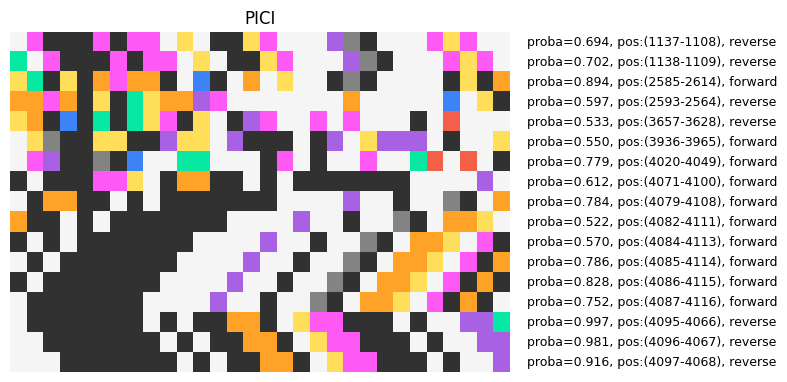

In [1]:
from pici_predictor.utilities import discover_pici

data_dir = "../dataset/demonstration_samples/GCF_000175755.1"
results_dir = "../results/demonstration/GCF_000175755.1"
model_function_path = "../models/best_configs"
model_pici_path = "../models/pici_classifier_model.json"
pici_segments = discover_pici(
    data_dir, results_dir, model_function_path, model_pici_path
)